In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.6 MB 3.3 MB/s 
     |████████████████████████████████| 190 kB 8.5 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7165, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 7165 (delta 47), reused 157 (delta 37), pack-reused 6988
Receiving objects: 100% (7165/7165), 13.86 MiB | 25.38 MiB/s, done.
Resolving deltas: 100% (5214/5214), done.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-23 16:20:51--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  9.63MB/s    in 32s     

2022-05-23 16:21:24 (9.82 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 128]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2

cfg.model.decode_head.loss_decode = [dict(type='CrossEntropyLoss', loss_weight = 1.0),
                                     dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]

In [11]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [12]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [13]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_lovasz'

In [14]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='CrossEntropyLoss', loss_weight=1.0),
            dict(type='DiceLoss'

### 모델 학습

In [15]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-23 16:21:40,651 - mmseg - INFO - Loaded 537 images
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-23 16:21:55,073 - mmseg - INFO - Loaded 113 images
2022-05-23 16:21:55,077 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-23 16:21:55,556 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 476s, ETA:     0s

2022-05-23 16:39:30,427 - mmseg - INFO - per class results:
2022-05-23 16:39:30,430 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.63 | 94.08 |
|  building  |  75.3 | 84.62 |
+------------+-------+-------+
2022-05-23 16:39:30,431 - mmseg - INFO - Summary:
2022-05-23 16:39:30,432 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.02 | 81.46 | 89.35 |
+-------+-------+-------+
2022-05-23 16:39:30,435 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9102, mIoU: 0.8146, mAcc: 0.8935, IoU.background: 0.8763, IoU.building: 0.7530, Acc.background: 0.9408, Acc.building: 0.8462
2022-05-23 16:40:04,567 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 5:11:49, time: 5.106, data_time: 4.791, memory: 3323, decode.loss_ce: 0.2610, decode.loss_dice: 0.0949, decode.loss_lovasz: 0.2430, decode.acc_seg: 89.5439, loss: 0.5989
2022-05-23 16:40:36,652 - mmseg - INFO - Iter [1200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-23 16:52:13,308 - mmseg - INFO - per class results:
2022-05-23 16:52:13,310 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.22 | 95.85 |
|  building  | 77.72 | 84.46 |
+------------+-------+-------+
2022-05-23 16:52:13,311 - mmseg - INFO - Summary:
2022-05-23 16:52:13,312 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.17 | 83.47 | 90.16 |
+-------+-------+-------+
2022-05-23 16:52:13,314 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9217, mIoU: 0.8347, mAcc: 0.9016, IoU.background: 0.8922, IoU.building: 0.7772, Acc.background: 0.9585, Acc.building: 0.8446
2022-05-23 16:52:45,421 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 4:22:47, time: 4.619, data_time: 4.303, memory: 3323, decode.loss_ce: 0.2488, decode.loss_dice: 0.0941, decode.loss_lovasz: 0.2331, decode.acc_seg: 89.7600, loss: 0.5760
2022-05-23 16:53:19,517 - mmseg - INFO - Iter [2200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 17:04:51,608 - mmseg - INFO - per class results:
2022-05-23 17:04:51,609 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.72 | 92.68 |
|  building  | 78.63 | 90.66 |
+------------+-------+-------+
2022-05-23 17:04:51,610 - mmseg - INFO - Summary:
2022-05-23 17:04:51,612 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.03 | 83.68 | 91.67 |
+-------+-------+-------+
2022-05-23 17:04:51,616 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9203, mIoU: 0.8368, mAcc: 0.9167, IoU.background: 0.8872, IoU.building: 0.7863, Acc.background: 0.9268, Acc.building: 0.9066
2022-05-23 17:05:23,393 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 3:56:56, time: 4.611, data_time: 4.299, memory: 3323, decode.loss_ce: 0.2226, decode.loss_dice: 0.0834, decode.loss_lovasz: 0.2103, decode.acc_seg: 91.2034, loss: 0.5163
2022-05-23 17:05:55,182 - mmseg - INFO - Iter [3200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 17:17:27,306 - mmseg - INFO - per class results:
2022-05-23 17:17:27,307 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.92 | 92.27 |
|  building  |  79.3 | 92.12 |
+------------+-------+-------+
2022-05-23 17:17:27,309 - mmseg - INFO - Summary:
2022-05-23 17:17:27,311 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.22 | 84.11 | 92.19 |
+-------+-------+-------+
2022-05-23 17:17:27,314 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9222, mIoU: 0.8411, mAcc: 0.9219, IoU.background: 0.8892, IoU.building: 0.7930, Acc.background: 0.9227, Acc.building: 0.9212
2022-05-23 17:17:59,139 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:37:23, time: 4.612, data_time: 4.299, memory: 3323, decode.loss_ce: 0.1849, decode.loss_dice: 0.0657, decode.loss_lovasz: 0.1789, decode.acc_seg: 92.6703, loss: 0.4294
2022-05-23 17:18:31,017 - mmseg - INFO - Iter [4200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 17:30:07,608 - mmseg - INFO - per class results:
2022-05-23 17:30:07,609 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.71 |  94.0 |
|  building  | 79.98 | 90.01 |
+------------+-------+-------+
2022-05-23 17:30:07,611 - mmseg - INFO - Summary:
2022-05-23 17:30:07,615 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.71 | 84.84 | 92.01 |
+-------+-------+-------+
2022-05-23 17:30:07,616 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9271, mIoU: 0.8484, mAcc: 0.9201, IoU.background: 0.8971, IoU.building: 0.7998, Acc.background: 0.9400, Acc.building: 0.9001
2022-05-23 17:30:39,619 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:20:48, time: 4.615, data_time: 4.300, memory: 3323, decode.loss_ce: 0.1994, decode.loss_dice: 0.0736, decode.loss_lovasz: 0.1950, decode.acc_seg: 91.9913, loss: 0.4680
2022-05-23 17:31:11,678 - mmseg - INFO - Iter [5200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 17:42:47,958 - mmseg - INFO - per class results:
2022-05-23 17:42:47,959 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.47 | 95.17 |
|  building  | 80.95 | 89.12 |
+------------+-------+-------+
2022-05-23 17:42:47,960 - mmseg - INFO - Summary:
2022-05-23 17:42:47,963 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.22 | 85.71 | 92.15 |
+-------+-------+-------+
2022-05-23 17:42:47,964 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9322, mIoU: 0.8571, mAcc: 0.9215, IoU.background: 0.9047, IoU.building: 0.8095, Acc.background: 0.9517, Acc.building: 0.8912
2022-05-23 17:43:20,145 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 3:05:30, time: 4.617, data_time: 4.301, memory: 3323, decode.loss_ce: 0.2058, decode.loss_dice: 0.0731, decode.loss_lovasz: 0.1937, decode.acc_seg: 91.9925, loss: 0.4726
2022-05-23 17:43:52,092 - mmseg - INFO - Iter [6200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 17:55:28,142 - mmseg - INFO - per class results:
2022-05-23 17:55:28,143 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.68 | 94.61 |
|  building  | 81.73 | 90.94 |
+------------+-------+-------+
2022-05-23 17:55:28,144 - mmseg - INFO - Summary:
2022-05-23 17:55:28,147 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.42 | 86.21 | 92.78 |
+-------+-------+-------+
2022-05-23 17:55:28,149 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9342, mIoU: 0.8621, mAcc: 0.9278, IoU.background: 0.9068, IoU.building: 0.8173, Acc.background: 0.9461, Acc.building: 0.9094
2022-05-23 17:56:00,282 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 2:50:55, time: 4.616, data_time: 4.301, memory: 3323, decode.loss_ce: 0.1838, decode.loss_dice: 0.0657, decode.loss_lovasz: 0.1777, decode.acc_seg: 92.7251, loss: 0.4273
2022-05-23 17:56:32,459 - mmseg - INFO - Iter [7200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-23 18:08:06,516 - mmseg - INFO - per class results:
2022-05-23 18:08:06,517 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.66 | 94.35 |
|  building  | 81.82 | 91.48 |
+------------+-------+-------+
2022-05-23 18:08:06,518 - mmseg - INFO - Summary:
2022-05-23 18:08:06,520 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.42 | 86.24 | 92.92 |
+-------+-------+-------+
2022-05-23 18:08:06,522 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9342, mIoU: 0.8624, mAcc: 0.9292, IoU.background: 0.9066, IoU.building: 0.8182, Acc.background: 0.9435, Acc.building: 0.9148
2022-05-23 18:08:40,615 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:36:49, time: 4.638, data_time: 4.323, memory: 3323, decode.loss_ce: 0.2014, decode.loss_dice: 0.0706, decode.loss_lovasz: 0.1882, decode.acc_seg: 91.9440, loss: 0.4602
2022-05-23 18:09:12,721 - mmseg - INFO - Iter [8200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 18:20:46,032 - mmseg - INFO - per class results:
2022-05-23 18:20:46,033 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.07 | 95.12 |
|  building  | 82.32 | 90.72 |
+------------+-------+-------+
2022-05-23 18:20:46,034 - mmseg - INFO - Summary:
2022-05-23 18:20:46,036 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.69 | 86.69 | 92.92 |
+-------+-------+-------+
2022-05-23 18:20:46,039 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9369, mIoU: 0.8669, mAcc: 0.9292, IoU.background: 0.9107, IoU.building: 0.8232, Acc.background: 0.9512, Acc.building: 0.9072
2022-05-23 18:21:18,078 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:22:59, time: 4.615, data_time: 4.301, memory: 3323, decode.loss_ce: 0.1710, decode.loss_dice: 0.0616, decode.loss_lovasz: 0.1679, decode.acc_seg: 93.1296, loss: 0.4005
2022-05-23 18:21:52,330 - mmseg - INFO - Iter [9200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 18:33:26,071 - mmseg - INFO - per class results:
2022-05-23 18:33:26,072 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.55 | 93.62 |
|  building  | 81.97 |  92.9 |
+------------+-------+-------+
2022-05-23 18:33:26,073 - mmseg - INFO - Summary:
2022-05-23 18:33:26,078 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.39 | 86.26 | 93.26 |
+-------+-------+-------+
2022-05-23 18:33:26,080 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9339, mIoU: 0.8626, mAcc: 0.9326, IoU.background: 0.9055, IoU.building: 0.8197, Acc.background: 0.9362, Acc.building: 0.9290
2022-05-23 18:33:58,122 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:09:25, time: 4.615, data_time: 4.300, memory: 3323, decode.loss_ce: 0.1484, decode.loss_dice: 0.0553, decode.loss_lovasz: 0.1532, decode.acc_seg: 94.1192, loss: 0.3568
2022-05-23 18:34:30,189 - mmseg - INFO - Iter [102

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 18:46:05,349 - mmseg - INFO - per class results:
2022-05-23 18:46:05,352 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.67 | 94.18 |
|  building  | 81.94 | 91.91 |
+------------+-------+-------+
2022-05-23 18:46:05,354 - mmseg - INFO - Summary:
2022-05-23 18:46:05,356 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.45 | 86.3 | 93.04 |
+-------+------+-------+
2022-05-23 18:46:05,358 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9345, mIoU: 0.8630, mAcc: 0.9304, IoU.background: 0.9067, IoU.building: 0.8194, Acc.background: 0.9418, Acc.building: 0.9191
2022-05-23 18:46:37,505 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 1:56:01, time: 4.616, data_time: 4.300, memory: 3323, decode.loss_ce: 0.1800, decode.loss_dice: 0.0629, decode.loss_lovasz: 0.1695, decode.acc_seg: 93.0722, loss: 0.4124
2022-05-23 18:47:09,461 - mmseg - INFO - Iter [11200/20

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 18:58:45,313 - mmseg - INFO - per class results:
2022-05-23 18:58:45,315 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.21 | 95.87 |
|  building  | 82.22 | 89.31 |
+------------+-------+-------+
2022-05-23 18:58:45,316 - mmseg - INFO - Summary:
2022-05-23 18:58:45,321 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.75 | 86.71 | 92.59 |
+-------+-------+-------+
2022-05-23 18:58:45,323 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9375, mIoU: 0.8671, mAcc: 0.9259, IoU.background: 0.9121, IoU.building: 0.8222, Acc.background: 0.9587, Acc.building: 0.8931
2022-05-23 18:59:17,056 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:42:44, time: 4.611, data_time: 4.299, memory: 3323, decode.loss_ce: 0.1568, decode.loss_dice: 0.0549, decode.loss_lovasz: 0.1547, decode.acc_seg: 93.5831, loss: 0.3664
2022-05-23 18:59:48,831 - mmseg - INFO - Iter [122

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 19:11:22,506 - mmseg - INFO - per class results:
2022-05-23 19:11:22,509 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.22 | 95.07 |
|  building  | 82.66 | 91.19 |
+------------+-------+-------+
2022-05-23 19:11:22,511 - mmseg - INFO - Summary:
2022-05-23 19:11:22,513 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.81 | 86.94 | 93.13 |
+-------+-------+-------+
2022-05-23 19:11:22,515 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9381, mIoU: 0.8694, mAcc: 0.9313, IoU.background: 0.9122, IoU.building: 0.8266, Acc.background: 0.9507, Acc.building: 0.9119
2022-05-23 19:11:54,381 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:29:31, time: 4.612, data_time: 4.299, memory: 3323, decode.loss_ce: 0.1712, decode.loss_dice: 0.0612, decode.loss_lovasz: 0.1665, decode.acc_seg: 93.2677, loss: 0.3989
2022-05-23 19:12:26,250 - mmseg - INFO - Iter [132

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 19:24:00,678 - mmseg - INFO - per class results:
2022-05-23 19:24:00,680 - mmseg - INFO - 
+------------+-------+------+
|   Class    |  IoU  | Acc  |
+------------+-------+------+
| background | 91.37 | 95.3 |
|  building  | 82.86 | 91.0 |
+------------+-------+------+
2022-05-23 19:24:00,681 - mmseg - INFO - Summary:
2022-05-23 19:24:00,683 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.91 | 87.12 | 93.15 |
+-------+-------+-------+
2022-05-23 19:24:00,685 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9391, mIoU: 0.8712, mAcc: 0.9315, IoU.background: 0.9137, IoU.building: 0.8286, Acc.background: 0.9530, Acc.building: 0.9100
2022-05-23 19:24:32,643 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:16:24, time: 4.613, data_time: 4.299, memory: 3323, decode.loss_ce: 0.1771, decode.loss_dice: 0.0630, decode.loss_lovasz: 0.1680, decode.acc_seg: 93.2197, loss: 0.4082
2022-05-23 19:25:04,723 - mmseg - INFO - Iter [14200/200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 19:36:37,220 - mmseg - INFO - per class results:
2022-05-23 19:36:37,222 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.53 | 95.39 |
|  building  | 83.17 | 91.18 |
+------------+-------+-------+
2022-05-23 19:36:37,223 - mmseg - INFO - Summary:
2022-05-23 19:36:37,228 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.03 | 87.35 | 93.29 |
+-------+-------+-------+
2022-05-23 19:36:37,230 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9403, mIoU: 0.8735, mAcc: 0.9329, IoU.background: 0.9153, IoU.building: 0.8317, Acc.background: 0.9539, Acc.building: 0.9118
2022-05-23 19:37:11,541 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:03:21, time: 4.638, data_time: 4.321, memory: 3323, decode.loss_ce: 0.1513, decode.loss_dice: 0.0548, decode.loss_lovasz: 0.1545, decode.acc_seg: 93.8456, loss: 0.3605
2022-05-23 19:37:43,706 - mmseg - INFO - Iter [152

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 19:49:15,467 - mmseg - INFO - per class results:
2022-05-23 19:49:15,469 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.01 | 94.02 |
|  building  | 82.75 |  93.1 |
+------------+-------+-------+
2022-05-23 19:49:15,471 - mmseg - INFO - Summary:
2022-05-23 19:49:15,473 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.72 | 86.88 | 93.56 |
+-------+-------+-------+
2022-05-23 19:49:15,476 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9372, mIoU: 0.8688, mAcc: 0.9356, IoU.background: 0.9101, IoU.building: 0.8275, Acc.background: 0.9402, Acc.building: 0.9310
2022-05-23 19:49:47,332 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:50:21, time: 4.612, data_time: 4.299, memory: 3323, decode.loss_ce: 0.1618, decode.loss_dice: 0.0611, decode.loss_lovasz: 0.1619, decode.acc_seg: 93.4837, loss: 0.3847
2022-05-23 19:50:21,244 - mmseg - INFO - Iter [162

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 20:01:54,766 - mmseg - INFO - per class results:
2022-05-23 20:01:54,767 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.45 | 95.45 |
|  building  | 82.97 | 90.85 |
+------------+-------+-------+
2022-05-23 20:01:54,769 - mmseg - INFO - Summary:
2022-05-23 20:01:54,771 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.97 | 87.21 | 93.15 |
+-------+-------+-------+
2022-05-23 20:01:54,774 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9397, mIoU: 0.8721, mAcc: 0.9315, IoU.background: 0.9145, IoU.building: 0.8297, Acc.background: 0.9545, Acc.building: 0.9085
2022-05-23 20:02:26,564 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:37:23, time: 4.613, data_time: 4.301, memory: 3323, decode.loss_ce: 0.1627, decode.loss_dice: 0.0587, decode.loss_lovasz: 0.1594, decode.acc_seg: 93.5085, loss: 0.3808
2022-05-23 20:03:00,552 - mmseg - INFO - Iter [172

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 20:14:30,541 - mmseg - INFO - per class results:
2022-05-23 20:14:30,542 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.38 | 94.95 |
|  building  | 83.06 | 91.83 |
+------------+-------+-------+
2022-05-23 20:14:30,545 - mmseg - INFO - Summary:
2022-05-23 20:14:30,547 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.94 | 87.22 | 93.39 |
+-------+-------+-------+
2022-05-23 20:14:30,550 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9394, mIoU: 0.8722, mAcc: 0.9339, IoU.background: 0.9138, IoU.building: 0.8306, Acc.background: 0.9495, Acc.building: 0.9183
2022-05-23 20:15:02,195 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:24:28, time: 4.610, data_time: 4.299, memory: 3323, decode.loss_ce: 0.1468, decode.loss_dice: 0.0530, decode.loss_lovasz: 0.1488, decode.acc_seg: 94.0193, loss: 0.3486
2022-05-23 20:15:34,130 - mmseg - INFO - Iter [182

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 20:27:09,729 - mmseg - INFO - per class results:
2022-05-23 20:27:09,730 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.48 | 94.91 |
|  building  | 83.28 | 92.14 |
+------------+-------+-------+
2022-05-23 20:27:09,732 - mmseg - INFO - Summary:
2022-05-23 20:27:09,733 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.02 | 87.38 | 93.53 |
+-------+-------+-------+
2022-05-23 20:27:09,739 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9402, mIoU: 0.8738, mAcc: 0.9353, IoU.background: 0.9148, IoU.building: 0.8328, Acc.background: 0.9491, Acc.building: 0.9214
2022-05-23 20:27:41,505 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:11:34, time: 4.611, data_time: 4.299, memory: 3323, decode.loss_ce: 0.1573, decode.loss_dice: 0.0566, decode.loss_lovasz: 0.1547, decode.acc_seg: 93.8374, loss: 0.3686
2022-05-23 20:28:13,214 - mmseg - INFO - Iter [192

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-23 20:39:47,714 - mmseg - INFO - per class results:
2022-05-23 20:39:47,716 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.55 |  95.2 |
|  building  | 83.31 | 91.68 |
+------------+-------+-------+
2022-05-23 20:39:47,717 - mmseg - INFO - Summary:
2022-05-23 20:39:47,720 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.06 | 87.43 | 93.44 |
+-------+-------+-------+
2022-05-23 20:39:47,722 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9406, mIoU: 0.8743, mAcc: 0.9344, IoU.background: 0.9155, IoU.building: 0.8331, Acc.background: 0.9520, Acc.building: 0.9168


### 모델 결과 시각화

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


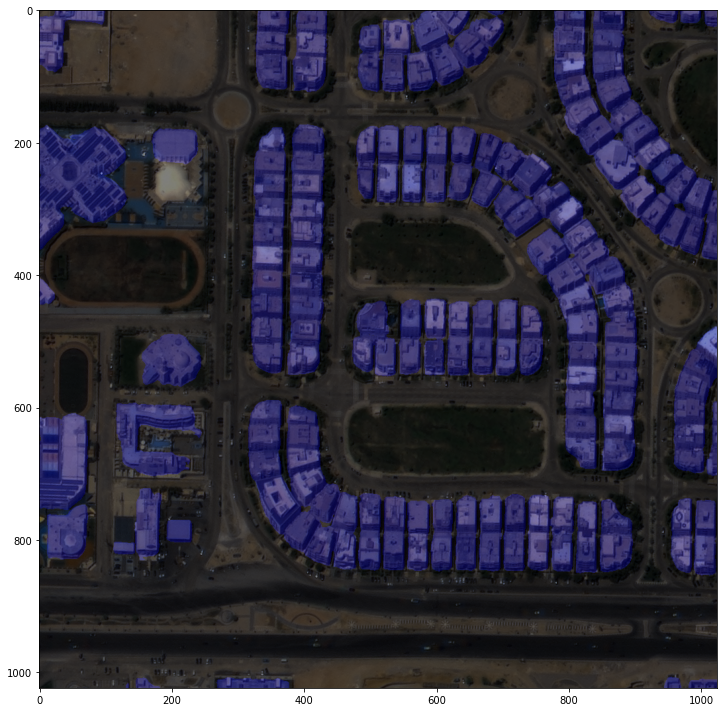

In [17]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


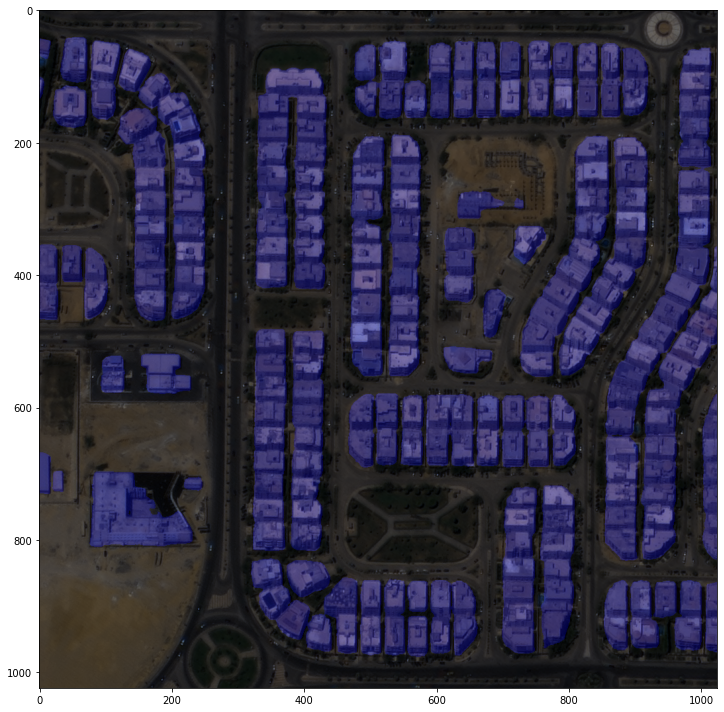

In [18]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


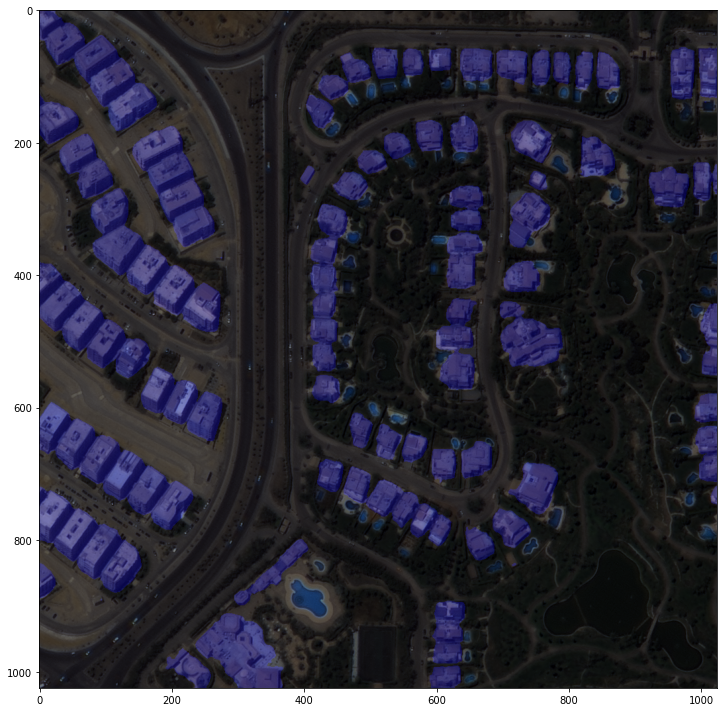

In [19]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


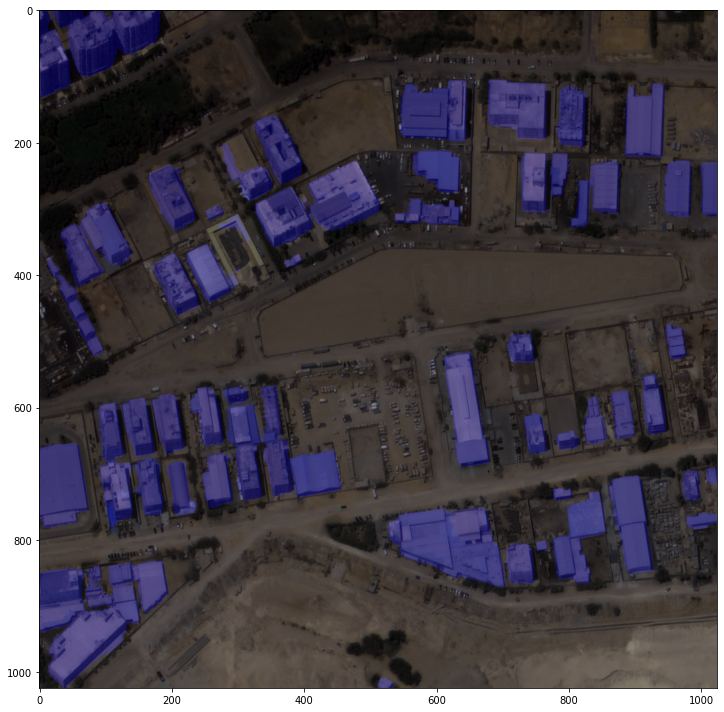

In [20]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_dice_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)